# <font color='orange'>DIP Exercise 08</font>

In [28]:
import numpy as np
import tifffile   # 用于读写TIFF图像文件的Python库
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.ndimage import geometric_transform   #对图像进行几何变换
from sklearn.neighbors import NearestNeighbors   #这是scikit-learn库中的一个类，用于执行最近邻搜索。

# Set random seed for reproducibility
np.random.seed(5)

In medical image processing, image registration is required to align, for example, an image of an individual subject with a population average. Registration is also necessary in case of multimodal recordings: If a patient's body is imaged with both MRI and PET, the images from the two modalities need to be aligned. Image registration is the process of computing and then applying the transformation that achieves this alignment.

在医学图像处理中，需要对图像进行配准，例如，将单个受试者的图像与总体平均值对齐。在多模式记录的情况下，配准也是必要的:如果患者的身体同时使用MRI和PET成像，则两种模式的图像需要对齐。图像配准是计算然后应用实现这种对齐的变换的过程。

<img src='question_sign.png' width=20px height=20px style="float:left;"> How can we automatically obtain a transformation from one image to another in the absence of a simple relationship, such as matching pixel intensities or texture?

在没有简单的关系(比如匹配像素强度或纹理)的情况下，我们如何自动获得从一张图像到另一张图像的转换?

Domain adaptation

Use more sophisticated similarity measures, eg. based on mutual information

Use manually placed external markers

<img src='question_sign.png' width=20px height=20px style="float:left;"> What is the difference between extrinsic and intrinsic registration?

外在配准和内在配准的区别是什么?

lntrinsic registration relies on features that are properties of the involved images, such as pixeintensities. Extrinsic registration is performed with external reference points, such as markersattached to the patient.

内在配准依赖于相关图像的属性特征，如像素强度。外部注册是通过外部参考点进行的，例如附着在患者身上的标记物。

<img src='question_sign.png' width=20px height=20px style="float:left;"> What is the difference between the fixed and the moving image in the context of image registration?

在图像配准的背景下，固定图像和运动图像有什么区别?

When performing registration, one image needs to remain unchanged, while the other image istransformed in order to minimize the misalignement. The image being transformed is calledmoving and the other one is called fixed.

在进行配准时，一幅图像需要保持不变，而另一幅图像则需要进行变换，以尽量减少配准误差。被变换的图像称为移动图像，另一个称为固定图像。

For demonstration we will again consider an image of fluorescently labeled membranes.为了演示，我们将再次考虑荧光标记膜的图像。

这段代码的目的是从HDF5文件中提取一个3D图像的特定区域，将其重新排列并显示在图像中。

3D Image shape: (236, 512, 512).


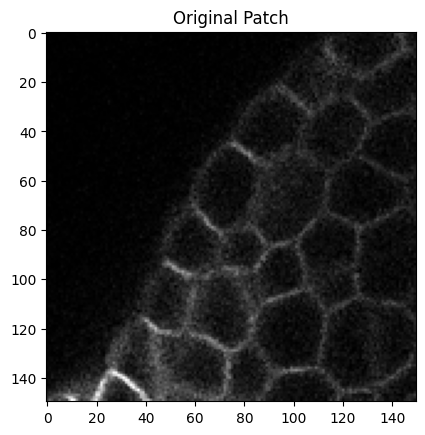

In [29]:
#HDF5 File
patch_size = [20, 150, 150]
pos = [50, 50, 50]
with h5py.File(r'thaliana_membranes_48h.h5', 'r') as h5_handle:
    img = h5_handle['data/image']
    print(f"3D Image shape: {img.shape}.")
    img_patch = img[pos[0]:pos[0]+patch_size[0], 
                    pos[1]:pos[1]+patch_size[1],
                    pos[2]:pos[2]+patch_size[2]]
    
#Transpose patch so that axes 1 to 3 are x-, y-, z-axis. Normalize patch.
img_patch = np.transpose(img_patch, axes=[1,2,0])
    
def plot_img(img, name):
    fig = plt.figure()
    ax = plt.gca()
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.set_title(name)

plot_img(img_patch, "Original Patch")
plt.show()

## Transformation

Homogeneous coordinates allow performing combinations of linear transformations through a single multiplication with a transformation matrix. Consider the following transformation matrix:
>$\begin{matrix}
m_1 & m_2 & m_3 & m_4\\
m_5 & m_6 & m_7 & m_8\\
m_9 & m_{10} & m_{11} & m_{12}\\
0 & 0 & 0 & 1\\
\end{matrix}$

齐次坐标允许通过与变换矩阵的单次乘法来执行线性变换的组合。考虑下面的变换矩阵:

<img src='question_sign.png' width=20px height=20px style="float:left;"> Which transformations can be performed with this transformation matrix?

Scaling, translation, affine such as rotation, reflection, shear

缩放、平移、旋转、反射、剪切等仿射

<img src='question_sign.png' width=20px height=20px style="float:left;">Which parameters have to be adjusted in order to apply scaling?

Parameters m1,m6 and m11

<img src='question_sign.png' width=20px height=20px style="float:left;"> How can a 2D image be reflected about the x-axis using the transformation matrix?

如何使用变换矩阵反映二维图像的x轴?

Change the sign of m6 (for a volume, m11 would also have a sign change)

<img src='exclamation_sign.png' width=20px height=20px style="float:left;"> Translate the 3D image patch loaded before by -5 pixels in x- and in y-direction using homogeneous coordinates and the backward warping technique!

使用齐次坐标和向后扭曲技术，将之前加载的3D图像补丁在x和y方向上平移-5像素!

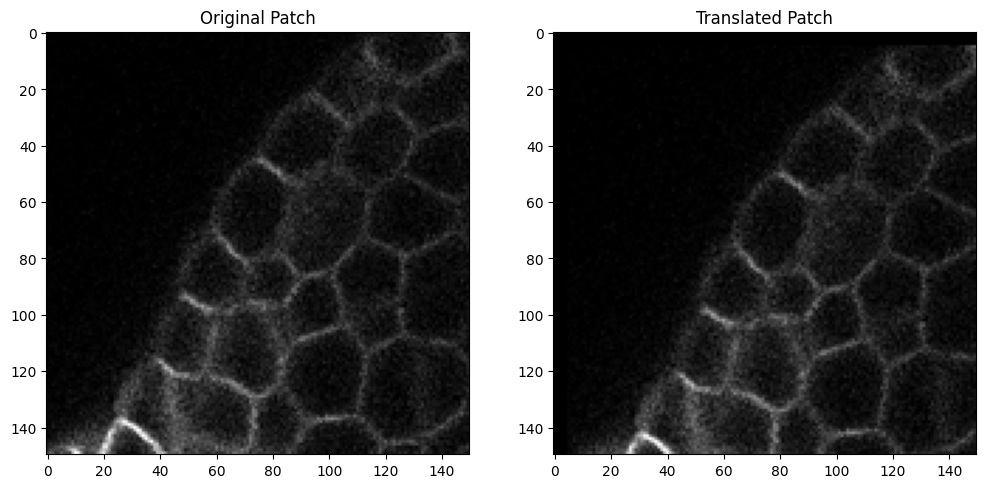

In [30]:
# Hint: the following lines give a list of size 4xN of all x-y-z positions in the image as homogeneous coordinates
coords = np.indices(img_patch.shape).reshape((3,-1))
coords = np.concatenate((coords, np.ones((1,coords.shape[1]))))

# Create the transformation matrix for translation
trafo_mat = np.array([[1, 0, 0, -5],
                      [0, 1, 0, -5],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

# Calculate the new positions
new_coords = np.matmul(trafo_mat, coords)

# Make sure to use integers
coords = coords.astype(int)
new_coords = new_coords.astype(int)

# Create the new image and fill it with the corresponding warped values
img_patch_trafo = np.zeros_like(img_patch)
for coord, new_coord in zip(coords.T, new_coords.T):
    if all([0 <= c < i for c, i in zip(new_coord, img_patch.shape)]):
        img_patch_trafo[tuple(coord[:-1])] = img_patch[tuple(new_coord[:-1])]

# Plot the original and translated patches
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_patch[..., 0], cmap='gray')
axes[0].set_title('Original Patch')
axes[1].imshow(img_patch_trafo[..., 0], cmap='gray')
axes[1].set_title('Translated Patch')
plt.show()


<img src='question_sign.png' width=20px height=20px style="float:left;">What is the biggest advantage of the backward warping approach in comparison to forward warping?

与前向翘曲相比，后向翘曲的最大优点是什么?

No holes will occur, whereas in forward warping inconsistencies can be created due to rounding or transformation-dependent skipping of target locations.

不会出现孔洞，而在正向翘曲中，由于目标位置的舍入或转换相关的跳过，可能会产生不一致。

## Similarity Measurement

The accuracy of a computed alignment can be measured by a metric. Metrics can be scores based on differences in pixel intensities (e.g. SSD or SAD) or on the correlation coefficient (e.g. NCC). More sophisticated information theory-based measures often rely on the degree of disorder as measured by the entropy.

计算准直的精度可以用度量来衡量。指标可以是基于像素强度差异(如SSD或SAD)或相关系数(如NCC)的分数。更复杂的基于信息理论的测量通常依赖于由熵测量的无序程度。

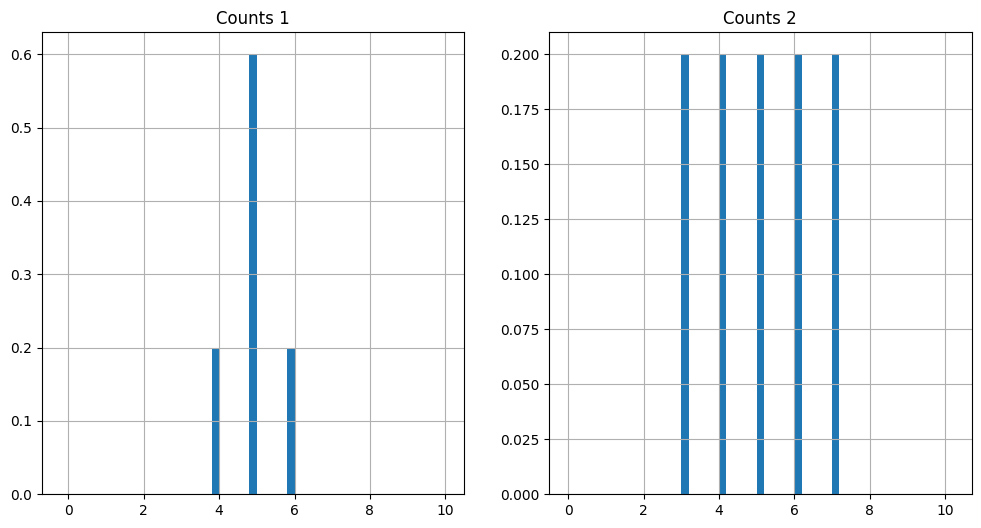

In [31]:
counts_1 = np.array([0,0,0,0,0.2,0.6,0.2,0,0,0,0]);
counts_2 = np.array([0,0,0,0.2,0.2,0.2,0.2,0.2,0,0,0]);
plt.figure(figsize=[12,6])
plt.subplot(1,2,1); plt.bar(np.arange(len(counts_1))-0.1, counts_1, width=0.2)
plt.title('Counts 1'); plt.grid()
plt.subplot(1,2,2); plt.bar(np.arange(len(counts_2))+0.1, counts_2, width=0.2)
plt.title('Counts 2'); plt.grid()
plt.show()

<img src='question_sign.png' width=20px height=20px style="float:left;"> The plots show two different frequency counts. Which of them has the smaller entropy? Give
reasons!

图中显示了两种不同的频率计数。哪一个的熵更小?给的原因!

1 has the smaller entropy, since it shows a sharp peak and is less uniformly distributed.

1的熵较小，因为它有一个尖峰，分布不均匀。

<img src='question_sign.png' width=20px height=20px style="float:left;"> Compute the entropies $H(x_1)$ and $H(x_2)$ for Count 1 and Count 2!

写本上了


In order to assess the alignment of two images, we need to compute the joint entropy, which is given by the following equation:

为了评估两幅图像的对齐，我们需要计算联合熵，由下式给出:

$H[X,Y]=-\sum_j\sum_ip_{XY}(i,j)\log_2p_{XY}(i,j)$

The same as for the 1D histograms also applies for images: if both images are aligned and hence create a very peaky histogram, the joint entropy will be minimal. To obtain joint probabilities, the joint histogram can be used, which counts pairwise occurrences of intensities at the same pixel position in both images.

1D直方图同样适用于图像:如果两个图像对齐，从而创建一个非常尖峰的直方图，联合熵将是最小的。为了获得联合概率，可以使用联合直方图，该直方图对两幅图像中相同像素位置的强度成对出现进行计数。

这段代码用于从一个3D图像数据集中提取三个补丁，并使用HDF5进行操作，然后绘制了这些补丁。

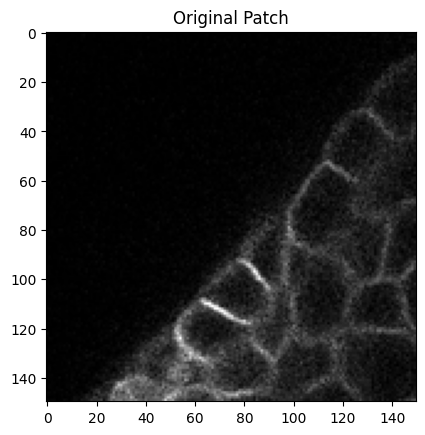

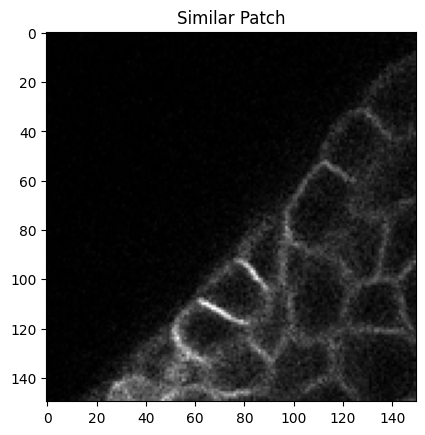

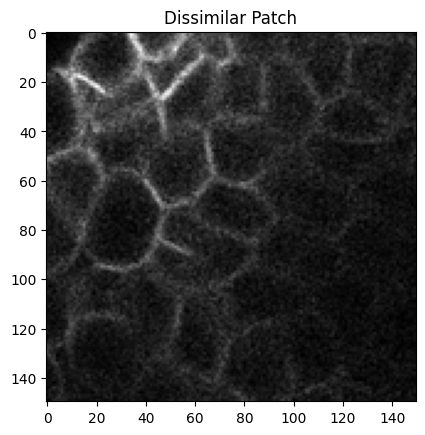

In [32]:
#Joint Historgram
pos = [1, 40, 1]
displacements = [[0, 0, 0],
                 [0, 0, 1],
                 [20, 150, 10]]
#Get 3 random patches
with h5py.File(r'thaliana_membranes_48h.h5', 'r') as h5_handle:
    img = h5_handle['data/image']
    patches = np.zeros([3,]+patch_size)
    for i in range(3):
        patch = img[pos[0]+displacements[i][0]:pos[0]+displacements[i][0]+patch_size[0],
                    pos[1]+displacements[i][1]:pos[1]+displacements[i][1]+patch_size[1],
                    pos[2]+displacements[i][2]:pos[2]+displacements[i][2]+patch_size[2]]
        patches[i,...] = patch
    patches = np.transpose(patches, axes=[0,2,3,1])
    
plot_img(patches[0,...], "Original Patch")
plot_img(patches[1,...], "Similar Patch")
plot_img(patches[2,...], "Dissimilar Patch")

生成两个图像之间的联合直方图

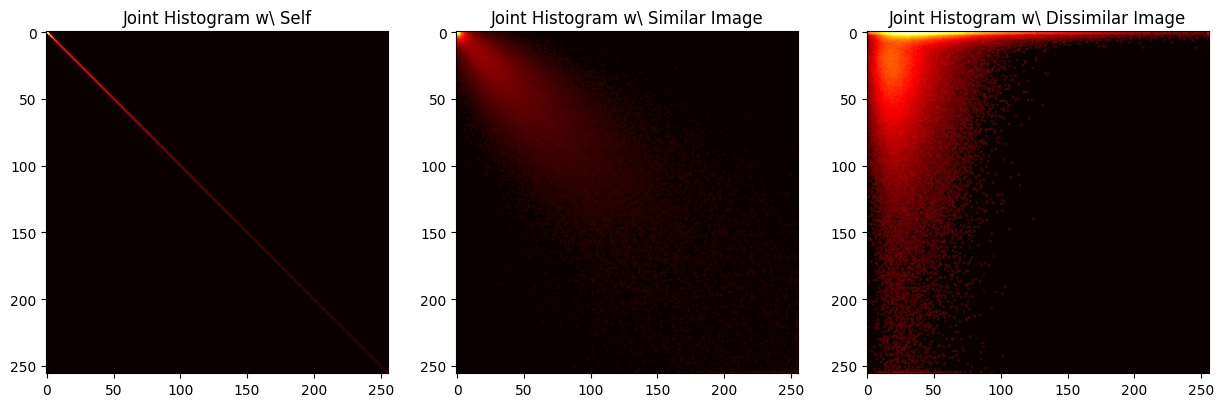

In [33]:
def make_joint_hist(moving, fixed):
    assert(moving.shape == fixed.shape)
    joint_histogram = np.zeros([256, 256])
    mf = moving.astype(np.uint8).flatten()
    ff = fixed.astype(np.uint8).flatten()
    for i in range(mf.size):
        joint_histogram[mf[i], ff[i]] += 1
    return joint_histogram / np.sum(joint_histogram)

histogram0 = make_joint_hist(patches[0,...], patches[0,...])
histogram1 = make_joint_hist(patches[0,...], patches[1,...])
histogram2 = make_joint_hist(patches[0,...], patches[2,...])

fig, axes = plt.subplots(1,3, figsize=(15, 15))
ax = axes.flat
ax[0].imshow(histogram0, norm=mpl.colors.PowerNorm(gamma=0.3), cmap='hot')
ax[0].set_title("Joint Histogram w\ Self")
ax[1].imshow(histogram1, norm=mpl.colors.PowerNorm(gamma=0.3), cmap='hot')
ax[1].set_title("Joint Histogram w\ Similar Image")
ax[2].imshow(histogram2, norm=mpl.colors.PowerNorm(gamma=0.3), cmap='hot')
ax[2].set_title("Joint Histogram w\ Dissimilar Image")
plt.show()

Still two dimensions, since the joint histogram only shows the joint occurrence of two intensities and does not consider location or dimensionality.

仍然是二维的，因为联合直方图只显示两个强度的联合发生，而不考虑位置或维度。

## Getting Started

We first set up two images to be aligned and then define
random corresponding markers in both images.

我们首先设置两个待对齐的图像，然后在两个图像中定义随机对应的标记。

所提供的代码似乎是在特定的 z 切片上可视化填充的图像块，并在图像上显示散点样本对应点。这可能是一个涉及图像处理或分析的更大过程的一部分。以下是代码的详细解释：

1. **填充图像块：** 图像块通过在每个维度上填充一半的大小来进行对称填充。这样做是为了确保样本对应点可以在有效位置上进行绘制。

2. **采样对应点：** 生成了一组采样对应点。这些点在图像块的每个维度上随机选择，选择范围基于图像块的维度，并选择以避免靠近边缘的点。

3. **在 Z 切片上绘制对应点：** 代码定义了一个名为 `plot_img_pts` 的函数，用于可视化填充的图像块以及样本对应点。用于可视化的 z 切片设置为填充图像块的中间 z 切片。该函数使用 `imshow` 来显示图像，然后在同一图上叠加样本点的散点图。

4. **可视化：** 调用函数 `plot_img_pts` 来在选定的 z 切片上绘制填充的图像块以及样本对应点。散点图显示与样本点的 x 和 y 坐标对应的点，同时使用 z 切片作为筛选条件。

总的来说，代码片段提供了一种方式来可视化填充的图像块以及随机采样的对应点，使您能够看到这些点在图像内的分布情况。这很可能是与图像处理或计算机视觉任务相关的分析或演示的一部分。

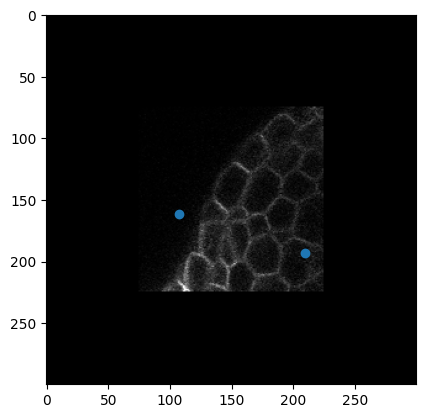

In [34]:
#Pad image patch for better visualization.
img_patch_padded = np.pad(img_patch, ((img_patch.shape[0]//2, img_patch.shape[0]//2), 
                                      (img_patch.shape[1]//2, img_patch.shape[1]//2),
                                      (img_patch.shape[2]//2, img_patch.shape[2]//2)))

#Sample correspondence points.
sample_pts = np.array([])
for i in range(img_patch.ndim):
    new_axis = np.random.randint(img_patch.shape[i]//2, high=3*img_patch.shape[i]//2, size=[50,1])
    sample_pts = np.concatenate((sample_pts, new_axis), axis=1) if sample_pts.size else new_axis

def plot_img_pts(img, pts):
    z_slice=img.shape[-1]//2
    fig = plt.figure()
    ax = plt.gca()
    ax.imshow(img[:, :, z_slice], cmap='gray')
    # imshow dimension has x as the vertical axis downwards and y as the horizontal axis.
    # Therefore use the reverse order of axis for plotting the scatter plots.
    ax.scatter([pts[i,1] for i in range(pts.shape[0]) if pts[i,2].astype(int) == z_slice],
               [pts[i,0] for i in range(pts.shape[0]) if pts[i,2].astype(int) == z_slice])
    
plot_img_pts(img_patch_padded, sample_pts)
plt.show()

这段代码看起来是将指定的变换应用于图像块和样本对应点，并在应用变换后的图像上绘制对应的样本点。以下是代码的解释：

1. **旋转矩阵：** 定义了一个名为 `rotation` 的旋转矩阵。这个矩阵实现了一个绕 Z 轴的二维旋转，通过 `rotation` 矩阵，坐标点将被旋转和平移。矩阵的形状为 4x4。

2. **应用变换：** 定义了一个名为 `apply_transform` 的函数，它将给定的变换应用于图像和样本对应点。这个函数使用了一个名为 `rot_func` 的嵌套函数，它实现了从输出坐标到输入坐标的反向变换。使用 `geometric_transform` 函数将旋转变换应用于输入图像，然后根据旋转矩阵计算旋转后的样本对应点。

3. **绘制对应点：** 调用函数 `apply_transform` 来应用旋转变换并获得旋转后的样本对应点和图像。然后，调用之前定义的 `plot_img_pts` 函数在旋转后的图像上绘制旋转后的样本对应点。

综上所述，代码段演示了如何应用旋转变换矩阵到图像块和样本对应点，然后在应用变换后的图像上绘制变换后的对应点，以展示图像和对应点之间的关系变化。

In [35]:
#Apply the tranformation and plot correspondences.

#Rotation matrix
rotation = np.array([[0.9, -0.5, 0, 150],
                     [0.5, 0.9, 0, -100],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def apply_transform(r, pc, img):
    #Rotation function
    def rot_func(output_coordinates):
        homogeneous_coordinates = np.array((*output_coordinates,1))
        return tuple((r.dot(homogeneous_coordinates))[:-1])

    img_moving = geometric_transform(img, rot_func, mode='constant')
    #Rotate sample_pts as well.
    pc_homo = np.pad(pc.T,((0,1), (0,0)), 'constant', constant_values=1)
    #rotation is the backward transformation matrx, therefore needs to be inverted.
    pc_moving = np.linalg.inv(r).dot(pc_homo)[:-1].T
    return pc_moving, img_moving

sample_pts_moving, img_patch_moving = apply_transform(rotation,
                                                      sample_pts,
                                                      img_patch_padded)
plot_img_pts(img_patch_moving, sample_pts_moving)

KeyboardInterrupt: 

这段代码将两个图像（一个是原始图像，另一个是经过变换后的图像）以及它们对应的样本点绘制在同一张图中，同时还在图中绘制了对应点之间的箭头来表示它们的对应关系。以下是代码的解释：

1. **函数定义：** 定义了一个名为 `plot_all` 的函数，用于绘制包含固定图像、移动图像、固定图像上的对应点和移动图像上的对应点的综合图。

2. **绘制图像和对应点：** 在绘制函数中，使用 `imshow` 函数分别绘制固定图像和移动图像。图像是在 x、y 平面上的一个特定 z 切片（`z_slice = img_fixed.shape[-1] // 2`）。

3. **绘制对应点：** 使用 `scatter` 函数绘制固定图像和移动图像上的对应点。仅绘制 z 切片与 `z_slice` 相同的对应点。

4. **绘制箭头：** 使用 `arrow` 函数在移动图像上的对应点和固定图像上的对应点之间绘制箭头，以表示它们之间的对应关系。箭头的方向和长度表示了对应点之间的映射关系。

5. **显示图像：** 显示绘制好的综合图，其中包含了固定图像、移动图像、对应点以及箭头。

综上所述，这段代码展示了如何将固定图像、移动图像、对应点和箭头在同一张图中进行绘制，以展示它们之间的对应关系和变换效果。

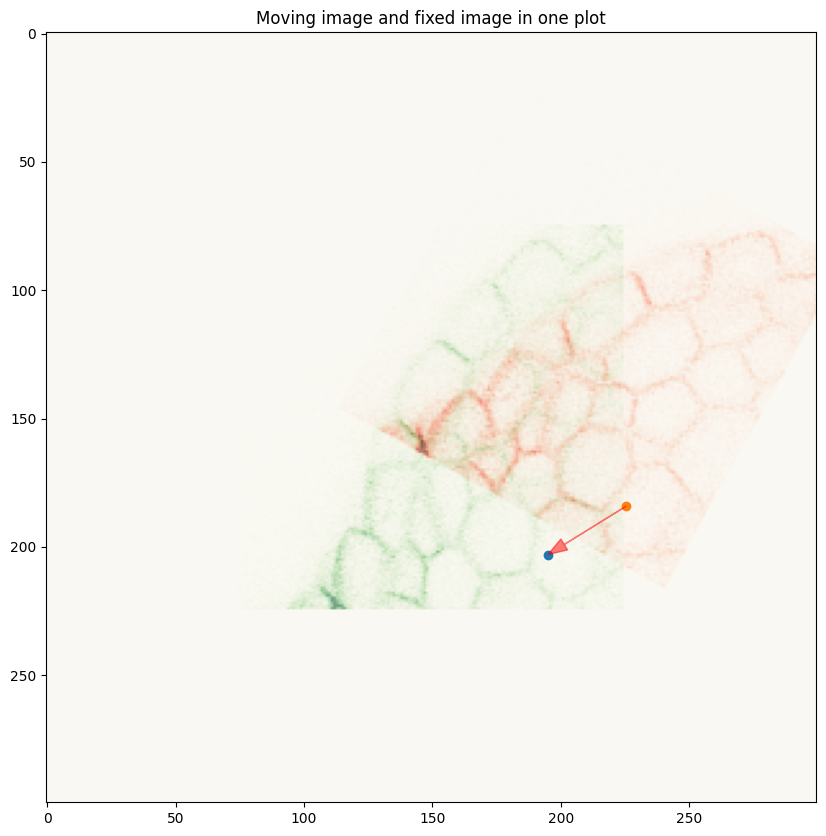

In [ ]:
def plot_all(img_fixed, img_moving, pts_fixed, pts_moving, plot_name):
    z_slice=img_fixed.shape[-1]//2
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.set_title(plot_name)
    ax.imshow(img_fixed[:, :, z_slice], cmap='Greens')
    ax.imshow(img_moving[:, :, z_slice], alpha=.5, cmap='Reds')
    #imshow dimension has x as the vertical axis and y as the horizontal axis.
    #Therefore use the reverse order of axis for plotting the scatter plots.
    ax.scatter([pts_fixed[i,1] for i in range(pts_fixed.shape[0]) if pts_fixed[i,2] == z_slice],
               [pts_fixed[i,0] for i in range(pts_fixed.shape[0]) if pts_fixed[i,2] == z_slice])
    ax.scatter([pts_moving[i,1] for i in range(pts_moving.shape[0]) if pts_moving[i,2] == z_slice],
               [pts_moving[i,0] for i in range(pts_moving.shape[0]) if pts_moving[i,2] == z_slice])
    
    # Plot arrows
    for pt_fixed, pt_moving in zip(pts_fixed, pts_moving):
        if pt_fixed[2] == z_slice and pt_moving[2] == z_slice:
            ax.arrow(pt_moving[1], pt_moving[0], 
                     pt_fixed[1]-pt_moving[1], pt_fixed[0]-pt_moving[0], 
                     length_includes_head=True, color='r', head_width=5, alpha=.5)

plot_all(img_patch_padded, img_patch_moving, sample_pts, sample_pts_moving, "Moving image and fixed image in one plot")

### Closed Form for Known Correspondences   已知信件封闭表格

In case corresponding points in both images are known, a rigid transformation can be calculated from the singular value decomposition (SVD) of the covariance matrix.

在两幅图像对应点已知的情况下，通过协方差矩阵的奇异值分解(SVD)进行刚性变换。

这段代码实现了一个使用已知对应关系的封闭形式解决方案，用于估计图像之间的刚性变换（包括旋转和平移）。以下是代码的解释：

1. **函数定义：** 定义了一个名为 `closed_form_transform` 的函数，用于根据已知的对应点关系估计图像之间的刚性变换。

2. **计算平移量和旋转矩阵：** 在函数内部，首先计算了移动点集和固定点集的平均值，然后分别将移动点集和固定点集减去其平均值，得到去均值的点集。接着，计算了移动点集和去均值的固定点集之间的协方差矩阵 `sigma`。

3. **奇异值分解：** 使用奇异值分解（SVD）将协方差矩阵 `sigma` 分解为三个矩阵：`u`、`s` 和 `v`。这些矩阵用于估计旋转矩阵 `r`。

4. **估计平移向量：** 使用已估计的旋转矩阵 `r`、移动点集的平均值和固定点集的平均值，计算得到最优的平移向量 `t_optimal`。

5. **构建齐次旋转矩阵：** 将旋转矩阵 `r` 和最优平移向量 `t_optimal` 连接起来，构建一个齐次旋转矩阵 `r`。

6. **应用变换：** 使用构建的齐次旋转矩阵 `r`，将移动点集和移动图像应用于变换，得到变换后的点集 `pc_moved` 和图像 `img_moved`。

7. **返回结果：** 函数返回变换后的点集 `pc_moved` 和图像 `img_moved`。

综上所述，这段代码演示了如何使用已知的对应点关系通过封闭形式求解来估计图像之间的刚性变换，包括旋转和平移。

In [ ]:
#Closed Form Solution for known correspondence.
def closed_form_transform(pc_moving, pc_fixed, img_moving):
    
    #Estimate R
    mean_fixed = np.mean(pc_fixed, axis=0)
    mean_moving = np.mean(pc_moving, axis=0)
    pc_fixed_demean = pc_fixed - mean_fixed
    pc_moving_demean = pc_moving - mean_moving
    sigma = pc_moving_demean.T.dot(pc_fixed_demean)
    u, _, v = np.linalg.svd(sigma, full_matrices=False)
    r = u.dot(v)
    t_optimal = mean_moving - r.dot(mean_fixed)
    
    #Pad with optimal translation to form homogeneous rotation matrix.
    r = np.concatenate((r, t_optimal[:,np.newaxis]), axis=1)
    r = np.concatenate((r, np.array([[0,0,0,1]])), axis=0)
    
    pc_moved, img_moved = apply_transform(r, pc_moving, img_moving)
    
    return pc_moved, img_moved

sample_pts_moved, img_patch_moved = closed_form_transform(sample_pts_moving, sample_pts, img_patch_moving)

应用封闭形式解决方案后，移动图像和固定图像的叠加效果，并在图像上显示了对应的点

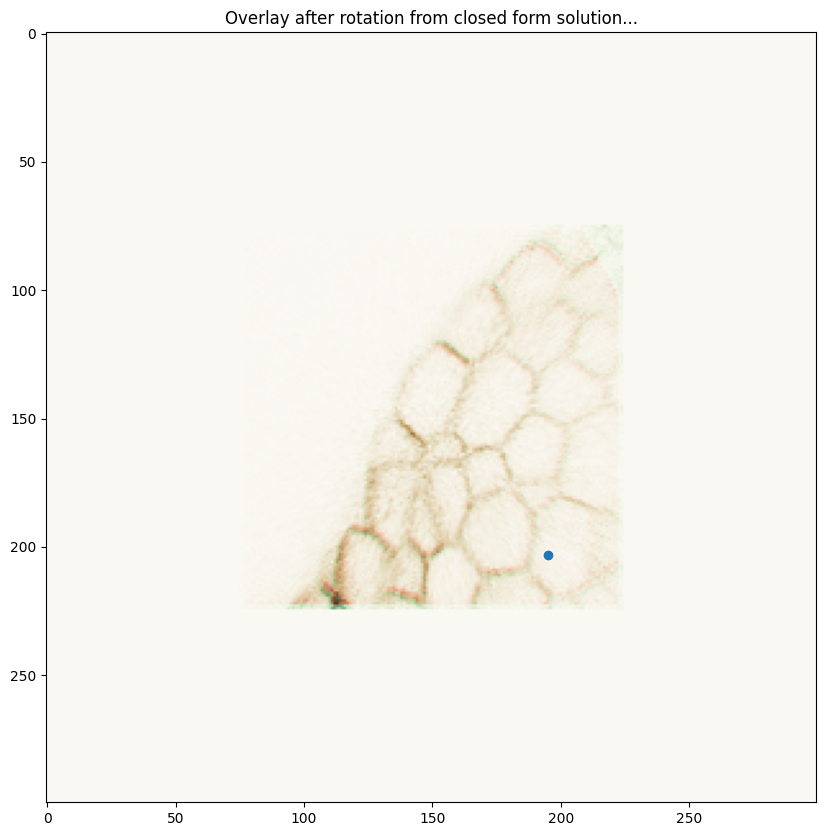

In [ ]:
plot_all(img_patch_padded, img_patch_moved, sample_pts, sample_pts_moved, 
         "Overlay after rotation from closed form solution...")

### Iterative Closest Point   迭代最近点

这段代码实现了迭代最近点（Iterative Closest Point，ICP）算法的函数。ICP算法用于将两个点云对齐，通过不断迭代寻找最佳的旋转和平移变换，使得两个点云的对应点之间的距离最小化。以下是代码的解释：

1. **函数定义：** `icp` 函数有四个参数，分别是移动点集 `pc_moving`、固定点集 `pc_fixed`、移动图像 `img_moving`、固定图像 `img_fixed` 和迭代次数 `it`。

2. **Nearest Neighbor搜索：** 在每次迭代中，首先使用 `NearestNeighbors` 对固定点集 `pc_fixed` 进行最近邻搜索，以找到每个移动点在固定点集中的最近邻点。这将生成一个索引数组 `idcs`，表示每个移动点的最近邻点的索引。

3. **避免重复最近邻：** 为了避免最近邻点的重复使用，使用 `count` 数组来记录每个固定点被使用的次数，然后在最近邻索引数组中选择一个不重复的索引。这样，每个固定点只会被一个移动点使用。

4. **闭合形式变换：** 使用 `closed_form_transform` 函数基于最近邻点的对应关系来估计旋转变换。然后，将移动点集和图像应用这个变换。

5. **迭代和可视化：** 根据迭代次数的奇偶性，使用 `plot_all` 函数可视化移动图像和固定图像的叠加效果，以及对应的点和箭头。这有助于观察每次迭代后的对齐情况。

6. **返回结果：** 最终，函数返回变换后的移动点集和图像。

综上所述，这段代码实现了ICP算法的迭代过程，通过寻找最佳的旋转和平移变换来对齐移动点集和固定点集，同时提供了可视化以便于观察对齐效果。

In [ ]:
def icp(pc_moving, pc_fixed, img_moving, img_fixed, it): 
    assert pc_moving.shape == pc_fixed.shape
    src = np.copy(pc_moving)
    dst = np.copy(pc_fixed)
    img_src = np.copy(img_moving)
    for i in range(it):
        
        #Nearest Neighbor
        nnbs = NearestNeighbors(n_neighbors=dst.shape[0]//2).fit(dst)
        dts, idcs = nnbs.kneighbors(src)
        
        #Avoid duplicate nn.
        count = np.ones((idcs.shape[0])) 
        indices = np.zeros((idcs.shape[0]))
        for ind, closest_points in enumerate(idcs):
            for pt in closest_points:
                if count[pt] > 0 or pt == closest_points[-1]:
                    indices[ind] = pt
                    count[pt] -=1
                    break
        print(f'Iteration {i}: index for nearest neighbor: {indices}, of which {np.unique(indices).size} are unique')
        
        #Estimate rotation via closed form solution, rotate moving pc & image
        pc_moved, img_moved = closed_form_transform(src, dst[indices.astype("int")], img_src)
        src = pc_moved
        img_src = img_moved
        
        #Visualization
        if i % 3 == 1:
            plot_all(img_fixed, img_moved, dst[indices.astype("int")], pc_moved, f"Iteration{i}")
            
    return src, img_src

看起来您正在使用ICP（迭代最近点）算法来对两个点云进行对齐，使用之前定义的icp函数。然后您正在使用plot_all函数绘制结果。这个过程涉及对点云进行排列，应用ICP算法，然后可视化结果。

In [37]:
# Permute point clouds.
perm = np.random.permutation(sample_pts_moving.shape[0])

# Call ICP
sample_pts_icp, img_patch_icp = icp(sample_pts_moving[perm], sample_pts, img_patch_moving, img_patch_padded, 15)

plot_all(img_patch_padded, img_patch_icp, sample_pts[perm], sample_pts_icp, "ICP results")

Iteration 0: index for nearest neighbor: [10. 26. 11. 32. 33.  9. 20.  3. 17.  0. 12. 30. 47. 48.  1. 44. 28. 37.
 43. 13. 39. 21. 35. 45. 16. 34. 19. 41. 31. 29. 25. 31. 27. 18. 15. 40.
 30.  1. 15. 49. 39. 27. 23. 29. 33. 15.  4. 27.  6. 24.], of which 40 are unique


KeyboardInterrupt: 

<img src='question_sign.png' width=20px height=20px style="float:left;"> If we had rotated the moving image by a much larger angle, would the ICP algorithm still achieve good
results? Give reasons!

如果我们将运动图像旋转一个更大的角度，ICP算法还会取得很好的效果吗?给的原因!

If the rotation is too large, most of the closest points would no longer be valid correspondencesTherefore, the algorithm would not be able to compute correct transformation parameters.

如果旋转太大，大多数最近的点将不再是有效的对应，因此，算法将无法计算正确的变换参数。

<img src='question_sign.png' width=20px height=20px style="float:left;"> Relating to the previous question, what is the most important prerequisite for achieving good results with the ICP algorithm?

关于上一个问题，ICP算法要想取得好的结果，最重要的先决条件是什么?

A good initial alignment is crucial

良好的初始对齐是至关重要的